In [1]:
import numpy as np
import neuropsy as npsy
import re
from tqdm import tqdm

## 1. Assign condition labels to subject's experiment dataframe

### 1.1 Assign Conditions - "Condition" column

In [72]:
path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)


for sub_id in tqdm(subject_ids, desc='Progress'):
    
    # load subject experiment data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_exp=True, load_chan=False, load_ieeg=False, load_targets=False)

    # get all item labels for the current subject
    item_names = np.unique([item.split('-')[0] for item in data.df_exp['Trial Identifier']])

    # add new column to dataframe to store condition
    data.df_exp['Condition'] = [None] * len(data.df_exp)

    for item in item_names:
        
        # compile regex pattern to search for all trials of the current item
        regex = re.compile(rf'^(?={item}-)[1-9]{{1,2}}', re.IGNORECASE)
        idx = np.where(data.df_exp['Trial Identifier'].str.contains(regex))[0]
        trial_numbers = np.sort([int(value.split('-')[1]) for value in data.df_exp['Trial Identifier'][idx]])

        for row in data.df_exp.loc[idx].iterrows():
            # check if trial error is below the acceptable threshold (150)
            if row[1]['Trial Error'] < 150:
                # last trial is assigned to condition "learned"
                if row[1]['Trial Identifier'] == f'{item}-{trial_numbers[-1]}':
                    data.df_exp.loc[row[0], 'Condition'] = 'learned'
                # second last trial is assigned to condition "learned-1"
                elif row[1]['Trial Identifier'] == f'{item}-{trial_numbers[-2]}':
                    data.df_exp.loc[row[0], 'Condition'] = 'learned-1'
                # trials that are within the acceptable threshold of error, but not the last or second to the last are assigned to condition "correct"
                else:
                    data.df_exp.loc[row[0], 'Condition'] = 'correct'
            # if trial error is above the acceptable threshold, it is assigned to condition "not learned"
            elif row[1]['Trial Error'] >= 150:
                data.df_exp.loc[row[0], 'Condition'] = 'not learned'
                
    # save dataframe with new condition column
    data.save(path=path, postfix='preprocessed', save_exp=True, save_ieeg=False, save_chan=False, save_targets=False, verbose=False)
    # break

Progress: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s]


### 1.2 Assign Condtions - "Condition (modified)" column

In [61]:
path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)


for sub_id in tqdm(subject_ids, desc='Progress'):
    
    # load subject experiment data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_exp=True, load_chan=False, load_ieeg=False, load_targets=False)

    # get all item labels for the current subject
    item_names = np.unique([item.split('-')[0] for item in data.df_exp['Trial Identifier']])

    # add new column to dataframe to store condition
    data.df_exp['Condition (modified)'] = None
    
    # copy old conditions "learned", "learned-1", and "correct" to new column, see below how "not learned" is handled
    for condition in ['learned', 'learned-1', 'correct']:
        idx = np.where(data.df_exp['Condition'] == condition)[0]
        data.df_exp.loc[idx, 'Condition (modified)'] = condition

    # for "not learned" only copy the trials with the highest error (1 trial if only one, 2 if more than one trials are above threshold)
    # first iterate over all items
    for item in item_names:
        
        # compile regex pattern to search for all trials of the current item
        regex = re.compile(rf'^(?={item}-)[1-9]{{1,2}}', re.IGNORECASE)
        idx = np.where(data.df_exp['Trial Identifier'].str.contains(regex))[0]
            
        # then get the indices of the trials that are "not learned"
        idx_not_learned = np.where(data.df_exp.loc[idx, 'Condition'] == 'not learned')[0]
        
        # if there is only one trial that is "not learned", only this trial is kept
        if len(idx_not_learned) == 1:
            idx_not_learned = idx_not_learned
        # if there are 2 trials or more that are "not learned", only the two trials with the highest error are kept
        elif len(idx_not_learned) >= 2:
            idx_not_learned = idx_not_learned[np.argsort(data.df_exp.loc[idx[idx_not_learned], 'Trial Error'])[-2:]]
        
        # assign the new condition "not learned" to the trials that are kept
        data.df_exp.loc[idx[idx_not_learned], 'Condition (modified)'] = 'not learned'
        
                
    # save dataframe with new condition column
    data.save(path=path, postfix='preprocessed', save_exp=True, save_ieeg=False, save_chan=False, save_targets=False, verbose=False)
    # break

Progress: 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]


In [62]:
item = '5'
regex = re.compile(rf'^(?={item}-)[1-9]{{1,2}}', re.IGNORECASE)
idx = np.where(data.df_exp['Trial Identifier'].str.contains(regex))[0]
        
data.df_exp.loc[idx]

,x_coordinate,y_coordinate,Picture Number,Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier,Trial Error,outlier,Trial Category,Condition,Condition (modified)
42,-213.0,195.0,5,19,144716,145937,282.648438,285.033203,2.384766,5-1,478.12,False,uncertain,not learned,None
97,-208.0,-140.0,5,19,327187,329056,639.037109,642.687500,3.650391,5-2,605.18,False,uncertain,not learned,not learned
116,-190.0,191.0,5,19,393677,394808,768.900391,771.109375,2.208984,5-3,455.64,False,uncertain,not learned,None
178,197.0,14.0,5,19,603053,605240,1177.837891,1182.109375,4.271484,5-4,235.44,False,uncertain,not learned,None
182,272.0,218.0,5,19,622214,624553,1215.261719,1219.830078,4.568359,5-5,23.77,False,certain,correct,correct
224,-2.0,-190.0,5,19,768133,770394,1500.259766,1504.675781,4.416016,5-6,505.10,False,uncertain,not learned,not learned
254,225.0,226.0,5,19,862428,865246,1684.429688,1689.933594,5.503906,5-7,40.50,False,certain,learned-1,learned-1
280,247.0,246.0,5,19,944349,945375,1844.431641,1846.435547,2.003906,5-8,17.09,False,certain,learned,learned


## 2. Display Selected Items with Trial Labels

### 2.1 Load Subject Data

In [63]:
path = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_id = '03'

data = npsy.DataHandler(path=path, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
data.load(load_saved=True, postfix='preprocessed', load_exp=True, load_chan=False, load_ieeg=False, load_targets=True)
data.df_exp.head()

,x_coordinate,y_coordinate,Picture Number,Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier,Trial Error,outlier,Trial Category,Condition,Condition (modified)
0,240.0,-252.0,47,3,5119,10133,9.998047,19.791016,9.792969,47-1,497.52,False,uncertain,not learned,not learned
1,247.0,-254.0,33,3,11738,14864,22.925781,29.031250,6.105469,33-1,376.75,False,uncertain,not learned,not learned
2,-248.0,200.0,36,3,16466,18582,32.160156,36.292969,4.132812,36-1,372.78,False,uncertain,not learned,not learned
3,-76.0,64.0,44,3,20187,26168,39.427734,51.109375,11.681641,44-1,211.44,True,uncertain,not learned,not learned
4,-252.0,-194.0,46,3,27774,29805,54.246094,58.212891,3.966797,46-1,163.09,False,uncertain,not learned,not learned


### 2.2 Get Trial Error and Trial Label for each Item

In [ ]:
# [IMPORTANT] select which condition column to use for plotting trial labels
label_column = 'Condition (modified)'

dict_eucl_distances = {}
for pic in data.df_targets['picture number'].unique():
    dict_eucl_distances[pic] = data.df_exp[data.df_exp['Picture Number'] == pic]['Trial Error'].to_list()
    
dict_trial_categories = {}
for pic in data.df_targets['picture number'].unique():
    dict_trial_categories[pic] = {}
    for trial, category in zip(range(1, len(data.df_exp[data.df_exp['Picture Number'] == pic]) + 1), data.df_exp[data.df_exp['Picture Number'] == pic][label_column]):
        if category is np.nan:
            continue
        else:
            dict_trial_categories[pic][trial] = category

### 2.3 Plot Selected Items and Their Trial Labels

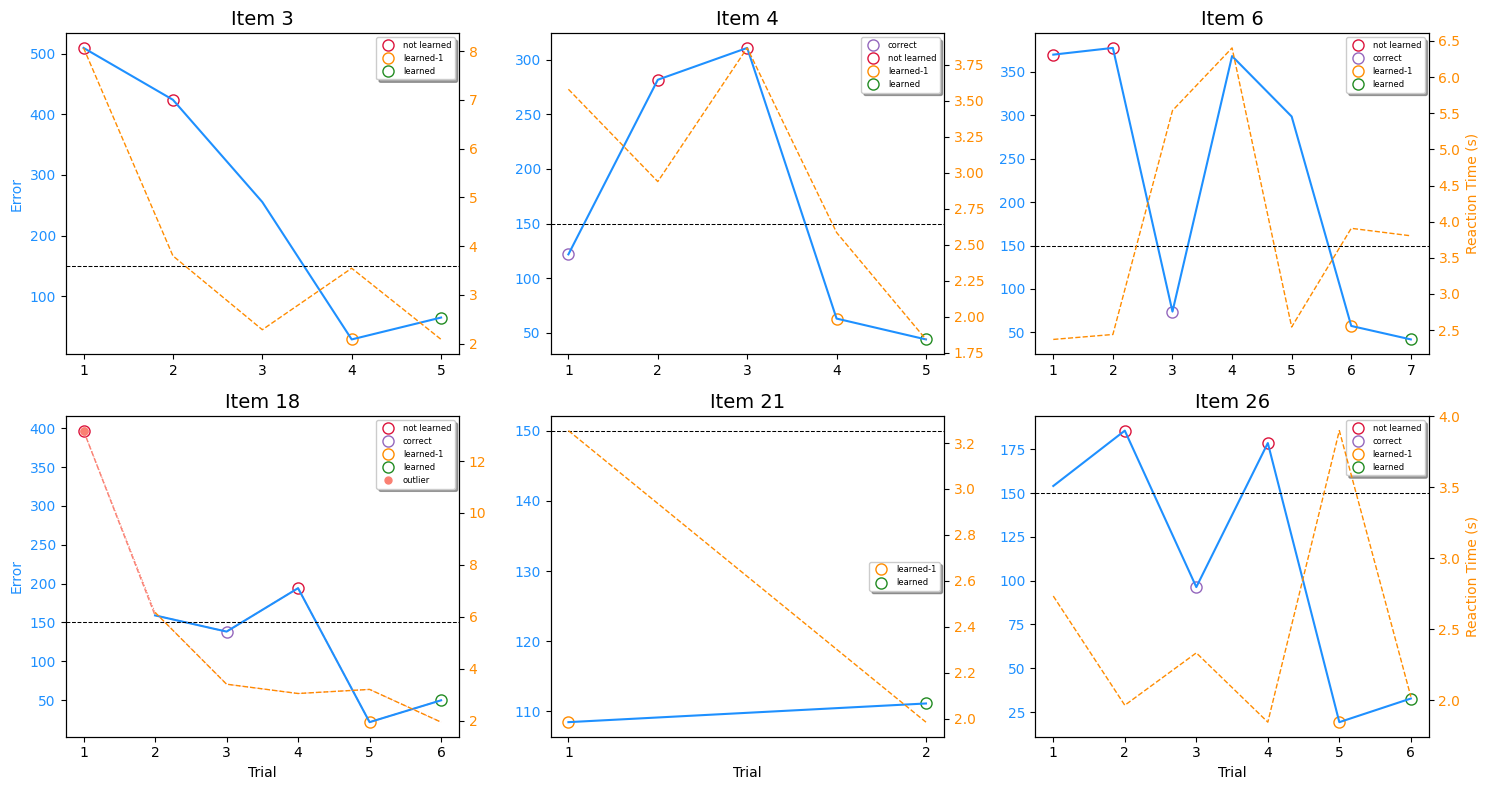

In [65]:
import matplotlib.pyplot as plt

item_numbers_to_plot = [3, 4, 6, 18, 21, 26] # change to items you want to plot
dict_trial_categories_plot = {}
for item in item_numbers_to_plot:
    dict_trial_categories_plot[item] = dict_trial_categories.get(item)

plot_colors = {
    'outlier': 'salmon',
    'error': 'dodgerblue',
    'reaction_time': 'darkorange',
    'threshold': 'black',
}

dict_category_colors = {
    'learned': 'forestgreen',
    'learned-1': 'darkorange',
    'correct': 'tab:purple',
    'not learned': 'crimson',
}

fig, axs = plt.subplots(nrows=2, ncols=len(item_numbers_to_plot)//2, figsize=(15, 8))
axs = axs.flatten()
for i, pic in zip(range(0, len(item_numbers_to_plot)), list(dict_trial_categories_plot.keys())):

    # create twin y axis
    ax2 = axs[i].twinx()

    # define x axis
    x_ticks = np.arange(0, len(dict_eucl_distances[pic]), step=1)
    x_ticks_labels = np.arange(1, len(dict_eucl_distances[pic]) + 1, step=1)

    # start with plotting big markers indicating trial categories
    seen_categories = []
    for trial, category in dict_trial_categories_plot[pic].items():
        if category is not None:
            # only set label one time for each category
            if category not in seen_categories:
                seen_categories.append(category)
                axs[i].plot(trial-1, dict_eucl_distances[pic][trial-1], marker='o', markersize=8, linestyle='None',
                            markerfacecolor='none', markeredgecolor=dict_category_colors[category], label=category)
            else:
                axs[i].plot(trial-1, dict_eucl_distances[pic][trial-1], marker='o', markersize=8, linestyle='None',
                            markerfacecolor='none', markeredgecolor=dict_category_colors[category])
        else:
            pass

    # check if item has outliers
    outlier_arr = data.df_exp[data.df_exp['Picture Number'] == pic]['outlier'].to_numpy(
    )
    outlier_indices = np.where(
        outlier_arr == True)[0]
    # ********** Has outliers **********#
    if len(outlier_indices) > 0:
        outlier_indices = outlier_indices.astype(int)

        # ********** Plot trial error **********#
        # plot error outlier dot and lines in red
        axs[i].plot(
            x_ticks, dict_eucl_distances[pic], color=plot_colors['outlier'], linestyle='--', linewidth=1)
        axs[i].plot(x_ticks[outlier_indices],
                    np.array(dict_eucl_distances[pic])[
            outlier_indices],
            marker='o',
            markersize=5,
            linestyle='None',
            color=plot_colors['outlier'],
            label='outlier')
        # plot non-outlier error in blue
        x = np.delete(x_ticks, outlier_indices)
        y1 = np.delete(
            dict_eucl_distances[pic], outlier_indices)
        # plot a dot if only one point else lines with no dots
        if len(y1) == 1:
            axs[i].plot(
                x, y1, marker='o', markersize=5, linestyle='None', color=plot_colors['error'])
        else:
            axs[i].plot(
                x, y1, color=plot_colors['error'], linestyle='-', linewidth=1.5)

        # ********** Plot reaction time **********#
        # plot outlier reaction time dot and line in red
        ax2.plot(data.df_exp[data.df_exp['Picture Number'] == pic]['Reaction Time (computed)'].to_numpy(),
                    color=plot_colors['outlier'], linestyle=':', linewidth=0.75)
        ax2.plot(x_ticks[outlier_indices], data.df_exp[data.df_exp['Picture Number'] == pic]['Reaction Time (computed)'].to_numpy()[
                    outlier_indices], marker='o', markersize=5, linestyle='None', color=plot_colors['outlier'])
        # plot non-outlier reaction times line in orange
        y2 = np.delete(
            data.df_exp[data.df_exp['Picture Number'] == pic]['Reaction Time (computed)'].to_numpy(), outlier_indices)
        # plot a dot if only one point else lines with no dots
        if len(y2) == 1:
            ax2.plot(
                x, y2, marker='o', markersize=5, linestyle='None', color=plot_colors['reaction_time'])
        else:
            ax2.plot(x, y2, color=plot_colors['reaction_time'],
                        linestyle='--', linewidth=1)

    # ********** No outliers **********#
    else:
        # ********** Plot trial error **********#
        axs[i].plot(
            dict_eucl_distances[pic], color=plot_colors['error'], linestyle='-', linewidth=1.5)
        # ********** Plot reaction time **********#
        ax2.plot(data.df_exp[data.df_exp['Picture Number'] == pic]['Reaction Time (computed)'].to_numpy(),
                    color=plot_colors['reaction_time'], linestyle='--', linewidth=1)

    axs[i].set_title(
        f'Item {pic}', fontsize=14)
    # only set x label for last row
    if i == 3 or i == 4 or i == 5:
        axs[i].set_xlabel('Trial', fontsize=10)
    # only set y1 ylabel for first plot
    axs[0].set_ylabel(
        'Error', fontsize=10, color=plot_colors['error'])
    axs[3].set_ylabel(
        'Error', fontsize=10, color=plot_colors['error'])
    # only set y2 label for last plot
    if i == len(item_numbers_to_plot)-1 or i == len(item_numbers_to_plot)-4:
        ax2.set_ylabel(
            "Reaction Time (s)", fontsize=10, color=plot_colors['reaction_time'])
    axs[i].axhline(y=150, color=plot_colors['threshold'],
                    linestyle='--', linewidth=0.75)
    axs[i].set_xticks(x_ticks, x_ticks_labels)
    axs[i].tick_params(
        axis='y', labelcolor=plot_colors['error'])
    ax2.tick_params(
        axis='y', labelcolor=plot_colors['reaction_time'])
    axs[i].legend(
        loc='best', fontsize=6, shadow=True)
    
save_path = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/preprocessing/categorise trials/automatic'
plt.savefig(f'{save_path}/trials_4_conditions_highest_error.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 3. Plot Trial Distribution

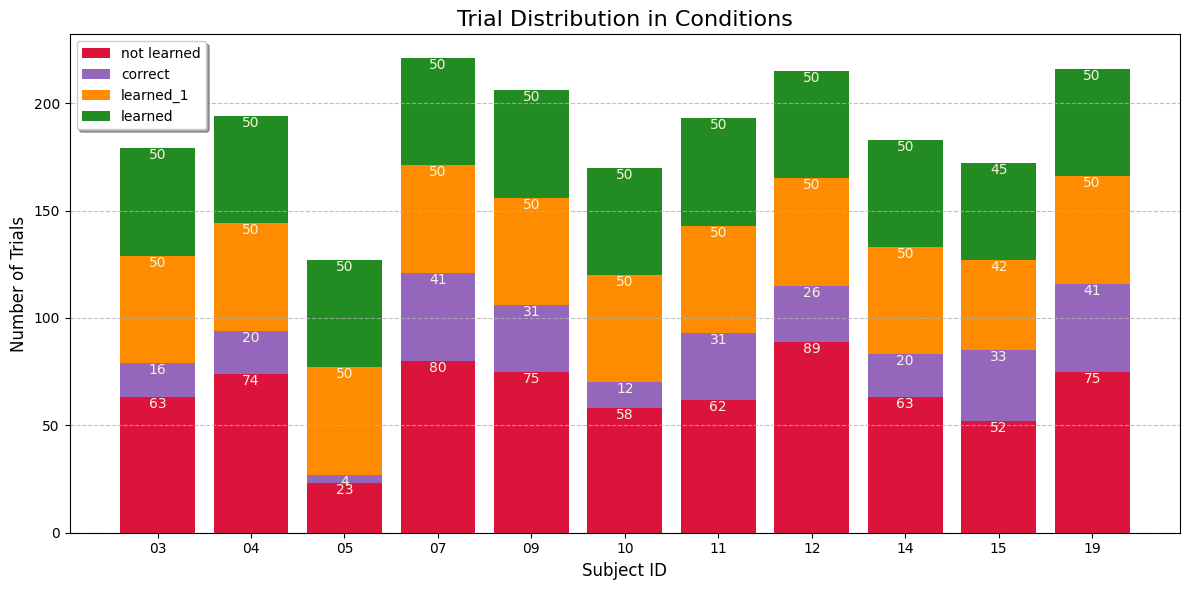

In [70]:
# [IMPORTANT] select which condition column to use for plotting trial labels
label_column = 'Condition (modified)'

import neuropsy as npsy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)

#******** Get labels for each subject ********
dict_subject_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_subject_labels[sub_id] = {}
    
    # load subject data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=False, load_ieeg=False, load_targets=False)
    
    # get labels
    for label in data.df_exp[label_column].unique():
        
        # first subject
        if i == 0:
            df = data.df_exp
        else:
            df = pd.concat([df, data.df_exp])
            
        dict_subject_labels[sub_id][label] = len(data.df_exp.loc[data.df_exp[label_column] == label])
        

#******** Plotting ********
conditions      = ['not learned', 'correct', 'learned-1', 'learned']
colors          = ['crimson', 'tab:purple', 'darkorange', 'forestgreen']

# dict_n_trials_in_category = {}
# for cat in trial_categories:
#     dict_n_trials_in_category[cat] = data.df_exp[data.df_exp['Trial Category'] == cat].shape[0]

not_learned     = [dict_subject_labels[sub_id]['not learned'] for sub_id in subject_ids]
correct         = [dict_subject_labels[sub_id]['correct'] for sub_id in subject_ids]
learned_1       = [dict_subject_labels[sub_id]['learned-1'] for sub_id in subject_ids]
learned         = [dict_subject_labels[sub_id]['learned'] for sub_id in subject_ids]
    
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(subject_ids, not_learned, label='not learned', color=colors[0], edgecolor='none')
ax.bar(subject_ids, correct, label='correct', color=colors[1], edgecolor='none', bottom=not_learned)
ax.bar(subject_ids, learned_1, label='learned_1', color=colors[2], edgecolor='none', bottom=[not_learned[i] + correct[i] for i in range(len(not_learned))])
ax.bar(subject_ids, learned, label='learned', color=colors[3], edgecolor='none', bottom=[not_learned[i] + correct[i] + learned_1[i] for i in range(len(not_learned))])
ax.grid(axis='y', linestyle='--', alpha=0.8)
ax.legend(loc='best', shadow=True)

# sns.set_theme(style="whitegrid")
# ax = sns.countplot(df, x="Subject ID", hue='Trial Category', palette=colors)
# ax.set_xticks([int(x) for x in subject_ids], subject_ids)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=9, label_type='edge', color='beige', padding=-11)

for sub_id in subject_ids:
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned'], s=dict_subject_labels[sub_id]['not learned'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct'], s=dict_subject_labels[sub_id]['correct'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct']+dict_subject_labels[sub_id]['learned-1'], s=dict_subject_labels[sub_id]['learned-1'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct']+dict_subject_labels[sub_id]['learned-1']+dict_subject_labels[sub_id]['learned'], s=dict_subject_labels[sub_id]['learned'], ha='center', va='top', fontsize=10, color='beige')

ax.set_title('Trial Distribution in Conditions', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=12)
ax.set_ylabel('Number of Trials', fontsize=12)
plt.tight_layout()
plt.savefig('/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/preprocessing/categorise trials/automatic/trial_distribution_conditions_highest_error.png', dpi=300)
plt.show()